# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re

## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)
print(set([s.split('::')[0].split('-')[-1] for s in nonPCAWG_wgs_mut.columns[2:]]))

{'Sarcoma', 'Ewings', 'Melanoma', 'RCC', 'AML', 'GBM', 'CMDI', 'AdenoCa', 'Endocrine', 'HCC', 'bone', 'BNHL', 'cancer', 'NOS', 'CLL', 'LGG', 'Medullo', 'ALL'}


In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [6]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Data cleanup and train-test split

In [68]:
import numpy as np
from collections import Counter

# mutations - mutation count dataset (e.g. PCAWG_wgs_mut)
# activities - sample mutation signature activities (e.g. PCAWG_wgs_act). Adds activities column-wise to the final dataset
# subtypes - boolean indicating whether or not to use cancer subtypes instead of cancer types
# sample_cutoff - number indicating how many (at least) samples need to be present to be included in the final dataset
# six_channels - boolean indicating whether to construct reduced 6-channel (summed over context) or full 96-channel dataset
# types_to_drop - a list of cancer types to drop manually (e.g. removing cancers that are hard to classify).
def construct_dataset(mutations, activities=None, subtypes=True, sample_cutoff=10, six_channels=False, types_to_drop=None):

    # Split "::" for cancer subtypes, "-" for general cancer types
    if subtypes:
        split = "::"
    else:
        split = "-"
    labels = [sample_name.split(split)[0] for sample_name in mutations.columns.values[2:]]
    
    # Either construct 6-channel of full 96-channel dataset
    if six_channels:
        channels6 = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
        temp = {}
        for c in channels6:
            new_row = np.zeros(mutations.shape[1]-2)
            for row in mutations.itertuples(index=True, name='Pandas'):
                if row[1] == c:
                    new_row += row[3:]
            temp[c] = new_row

        data = pd.DataFrame(data=temp).T
        data.columns = mutations.columns[2:]
        data = data.T
    else:
        data = mutations.iloc[:, 2:].T
        data.columns = mutations["Mutation type"] + "_" + mutations["Trinucleotide"]
    
    # Add activities if they are provided
    if activities is not None:
        activities.index = activities["Cancer Types"] + "::" + activities["Sample Names"]
        data = data.join(activities.iloc[:, 3:])
    
    data["Type"] = labels

    # Remove samples of cancer types that appear less than n=sample_cutoff times
    to_drop_types = [x for x in labels if Counter(labels)[x] <= sample_cutoff]

    if types_to_drop is not None:
        to_drop_types += types_to_drop
    
    print("Dropping:", sorted(set(to_drop_types)))
    
    to_drop_samples = [sample_name for sample_name in data.index.values if sample_name.split(split)[0] in to_drop_types]
    data = data.drop(to_drop_samples)
    
    return data

In [69]:
data = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=False, six_channels=False, sample_cutoff=50, 
                         types_to_drop=["Head", "Bone", "Stomach"])

Dropping: ['Biliary', 'Bladder', 'Bone', 'Cervix', 'Head', 'SoftTissue', 'Stomach', 'Thy']


# Random Forest

Accuracy:  0.8465346534653465
Mean Absolute Error: 0.9653465346534653
Mean Squared Error: 8.001650165016502
Root Mean Squared Error: 2.8287188204232145


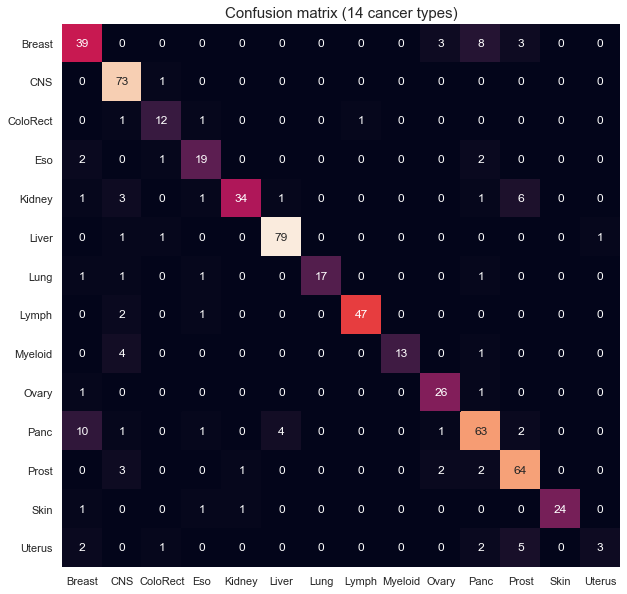

'\nimportances = rf.feature_importances_\nindices = np.argsort(importances)[::-1]\nplt.figure(figsize=(20,5))\nplt.title("Feature importances")\nplt.bar(range(x.shape[1]), importances[indices], color="r", align="center")\nplt.xticks(range(x.shape[1]), data.columns[indices], rotation=90)\nplt.show()\n'

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn.apionly as sns

x = np.array(data)
#x = np.array(data[data["Type"] == "Biliary-AdenoCA"])
y = np.array(x[:, -1])

# Convert labels to numbers
to_int = {}
y_labs = list(sorted(set(y)))
for i in range(len(y_labs)):
    to_int[y_labs[i]] = i
to_label = {x: y for y, x in to_int.items()}
    
y = [to_int[x] for x in y]


x = x[:, :-1]
x = x/x.sum(axis=1)[:, np.newaxis] # Normalize row values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y)
rf = RandomForestClassifier()
rf.fit(train_x, train_y)

rf_predictions = rf.predict(test_x)
print("Accuracy: ", sum(rf_predictions == test_y)/len(test_y))
print("Mean Absolute Error:", metrics.mean_absolute_error(test_y, rf_predictions))
print("Mean Squared Error:", metrics.mean_squared_error(test_y, rf_predictions))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(test_y, rf_predictions)))

plot_labels = sorted(set([to_label[x] for x in y]))
cmat = metrics.confusion_matrix(test_y, rf_predictions)
sns.set(rc={"figure.figsize":(10,10)})
ax = plt.axes()
sns.heatmap(cmat, annot=True, cbar=False, xticklabels=plot_labels, yticklabels=plot_labels)
ax.set_title(("Confusion matrix (" + str(len(set(y))) + " cancer types)"), fontsize=15)
plt.show()

'''
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x.shape[1]), data.columns[indices], rotation=90)
plt.show()
'''